# 低阶API

低阶API包括张量操作、计算图和自动微分

In [1]:
import tensorflow as tf

In [13]:
(tf.timestamp()%(24*60*60)//(3600)+8)%(24)

<tf.Tensor: id=31, shape=(), dtype=float64, numpy=15.0>

In [77]:
# 打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)
    
    hour = tf.cast(today_ts//3600+8, tf.int32) % tf.constant(24)
    minit = tf.cast(today_ts%3600//60, tf.int32)
    second = tf.cast(tf.floor(today_ts%60), tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format('{}', m)) == 1:
            return tf.strings.format('0{}', m)
        else:
            return tf.strings.format('{}', m)
        
    timestring = tf.strings.join([timeformat(hour), timeformat(minit), timeformat(second)], separator=':')
    tf.print('========'*8 + timestring)

# 1. 线性回归模型

In [78]:
# 准备数据
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

# 数据样本
n = 400

x = tf.random.uniform([n, 2], minval=-10, maxval=10)
w0 = tf.constant([[2.0], [-3.0]])
b0 = tf.constant([[3.0]])
y = x@w0 + b0 + tf.random.normal([n, 1], mean=0.0, stddev=2.0)    # @表示矩阵乘法,增加正态扰动

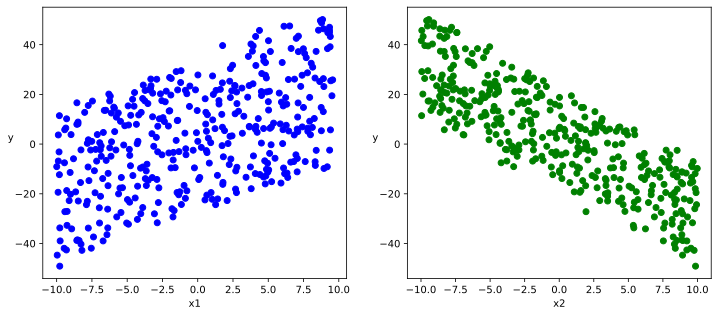

In [79]:
# 数据展示
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(x[:, 0], y[:, 0], c='b')
plt.xlabel('x1')
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(x[:, 1], y[:, 0], c='g')
plt.xlabel('x2')
plt.ylabel('y', rotation=0)
plt.show()

In [80]:
# 构建数据管道迭代器
def iter_data(feature, label, batch_size=8):
    num_example = len(feature)
    indices = list(range(num_example))
    np.random.shuffle(indices)
    for i in range(0, num_example, batch_size):
        index = indices[i: min(i+batch_size, num_example)]
        yield tf.gather(feature, index), tf.gather(label, index)
        
feature, label = next(iter_data(x, y, batch_size=8))
print(feature)
print(label)

tf.Tensor(
[[-0.8743744   7.353403  ]
 [ 0.14596176  5.9499598 ]
 [-5.513177    4.3311577 ]
 [-1.3469486   6.6516476 ]
 [-4.0069866  -5.374248  ]
 [-7.278211    3.5198002 ]
 [ 2.0850391   9.4603195 ]
 [ 5.120304    2.6020288 ]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[-21.830906]
 [-13.442729]
 [-17.691595]
 [-20.404285]
 [ 12.755119]
 [-19.587734]
 [-22.737915]
 [  6.359916]], shape=(8, 1), dtype=float32)


## 1.1 定义模型

In [81]:
w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0, dtype=tf.float32))

class LinearRegression():
    # 正向传播
    def __call__(self, x):
        return x@w + b
    
    # 损失函数
    def loss_func(self, y_true, y_pred):
        return tf.reduce_mean((y_pred - y_true)**2/2)

model = LinearRegression()

## 1.2 训练模型

In [82]:
# 使用动态图调式
def train_step(model, feature, label):
    with tf.GradientTape() as tape:
        predictions = model(feature)
        loss = model.loss_func(label, predictions)
    # 反向传播求梯度
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
    # 梯度下降法更新参数
    w.assign(w - 0.001*dloss_dw)
    b.assign(b - 0.001*dloss_db)
    
    return loss

In [83]:
# 测试Train_step的效果
feature, label = next(iter_data(x, y, batch_size=10))
train_step(model, feature, label)

<tf.Tensor: id=481138, shape=(), dtype=float32, numpy=304.4083>

In [88]:
def train_model(model, epochs):
    for i in range(1, epochs+1):
        for feature, label in iter_data(x, y, batch_size=10):
            loss = train_step(model, feature, label)
        
        if i%50 == 0:
            printbar()
            tf.print('epochs=', i, 'loss=', loss)
            tf.print('w=', w)
            tf.print('b=', b)

train_model(model, 200)

================================================================17:42:50
epochs= 50 loss= 1.59645176
w= [[1.99504483]
 [-2.99818039]]
b= [[3.31977272]]
================================================================17:42:55
epochs= 100 loss= 1.34867859
w= [[1.98884761]
 [-2.99184656]]
b= [[3.31966376]]
================================================================17:43:00
epochs= 150 loss= 1.6174705
w= [[1.99206233]
 [-2.99816799]]
b= [[3.32082343]]
================================================================17:43:05
epochs= 200 loss= 3.55890703
w= [[2.0045774]
 [-2.99746299]]
b= [[3.32022262]]


In [89]:
# 使用autograph机制转为静态图加速

@tf.function
def train_step(model, feature, label):
    with tf.GradientTape() as tape:
        predictions = model(feature)
        loss = model.loss_func(label, predictions)
    # 反向传播求梯度
    dloss_dw, dloss_db = tape.gradient(loss, [w, b])
    # 梯度下降法更新参数
    w.assign(w - 0.001*dloss_dw)
    b.assign(b - 0.001*dloss_db)
    
    return loss

def train_model(model, epochs):
    for i in range(1, epochs+1):
        for feature, label in iter_data(x, y, batch_size=10):
            loss = train_step(model, feature, label)
        if i%50 == 0:
            printbar()
            tf.print('epochs=', i, 'loss=', loss)
            tf.print('w=', w)
            tf.print('b=', b)

train_model(model, 200)

================================================================17:45:39
epochs= 50 loss= 1.57074797
w= [[1.99427259]
 [-2.99915409]]
b= [[3.32043314]]
================================================================17:45:40
epochs= 100 loss= 1.62854218
w= [[1.99595296]
 [-3.00273037]]
b= [[3.32046437]]
================================================================17:45:41
epochs= 150 loss= 1.71901345
w= [[1.99244797]
 [-2.99692917]]
b= [[3.32012773]]
================================================================17:45:42
epochs= 200 loss= 2.87456441
w= [[1.99607682]
 [-2.99166155]]
b= [[3.31991315]]


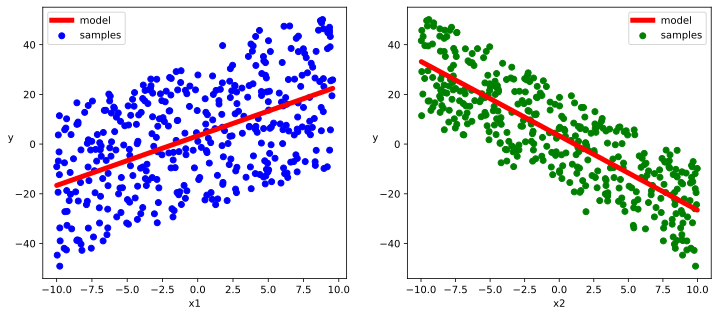

In [97]:
# 结果可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(x[:, 0], y[:, 0], c='b', label='samples')
ax1.plot(x[:, 0], w[0]*x[:, 0]+b[0], '-r', linewidth=5.0, label='model')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y', rotation=0)

ax2 = plt.subplot(122)
ax2.scatter(x[:, 1], y[:, 0], c='g', label='samples')
ax2.plot(x[:, 1], w[1]*x[:, 1]+b[0], '-r', linewidth=5.0, label='model')
ax2.legend()
plt.xlabel('x2')
plt.ylabel('y', rotation=0)
plt.show()

# 2. DNN二分类模型

## 2.1 数据准备

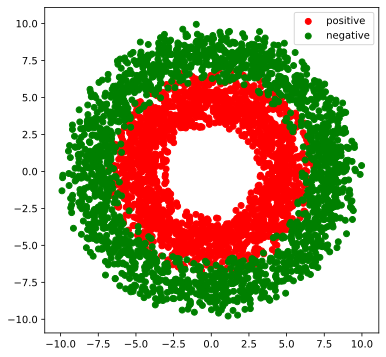

In [167]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 样本数量
n_positive, n_negative = 2000, 2000

# 生成正样本，小圆环
r_p = 5.0 + tf.random.truncated_normal([n_positive, 1], 0.0, 1.0)
theta_p = tf.random.uniform([n_positive, 1], 0.0, 2*np.pi)
Xp = tf.concat([r_p*tf.cos(theta_p), r_p*tf.sin(theta_p)], axis=1)
Yp = tf.ones_like(r_p)

# 生成负样本，大圆环
r_n = 8.0 + tf.random.truncated_normal([n_negative, 1], 0.0, 1.0)
theta_n = tf.random.uniform([n_negative, 1], 0, 2*np.pi)
Xn = tf.concat([r_n*tf.cos(theta_n), r_n*tf.sin(theta_n)], axis=1)
Yn = tf.zeros_like(r_n)

# 样本汇总
X = tf.concat([Xp, Xn], axis=0)
Y = tf.concat([Yp, Yn], axis=0)

# 绘图
plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0].numpy(), Xp[:, 1].numpy(), c='r')
plt.scatter(Xn[:, 0].numpy(), Xn[:, 1].numpy(), c='g')
plt.legend(['positive', 'negative'])

In [168]:
# 构建数据管道迭代器
def data_iter(feature, label, batch_size=10):
    num_example = len(feature)
    indices = list(range(num_example))
    np.random.shuffle(indices)
    for i in tf.range(0, num_example, batch_size):
        index = indices[i: min(i+batch_size, num_example)]
        yield tf.gather(feature, index), tf.gather(label, index)
        
# 测试
features, labels = next(data_iter(X, Y, batch_size=10))
print(features)
print(labels)

tf.Tensor(
[[-0.31027246  7.3054357 ]
 [ 5.4298882  -0.92607   ]
 [ 1.4413218  -6.22379   ]
 [ 2.6271765  -8.133517  ]
 [-6.1708345  -4.2128797 ]
 [ 1.0243052  -4.4060564 ]
 [ 0.15604857  7.1951165 ]
 [-4.677436   -0.04655211]
 [-3.6251423   5.1228    ]
 [ 3.3680105   1.625666  ]], shape=(10, 2), dtype=float32)
tf.Tensor(
[[0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]], shape=(10, 1), dtype=float32)


## 2.2 定义模型

利用tf.Module来组织模型变量

In [169]:
class DNNModel(tf.Module):
    def __init__(self, name=None):
        super(DNNModel, self).__init__(name=name)
        self.w1 = tf.Variable(tf.random.truncated_normal([2, 4]), dtype=tf.float32)
        self.b1 = tf.Variable(tf.zeros([1, 4]), dtype=tf.float32)
        self.w2 = tf.Variable(tf.random.truncated_normal([4, 8]), dtype=tf.float32)
        self.b2 = tf.Variable(tf.zeros([1, 8]), dtype=tf.float32)
        self.w3 = tf.Variable(tf.random.truncated_normal([8, 1]), dtype=tf.float32)
        self.b3 = tf.Variable(tf.zeros([1, 1]), dtype=tf.float32)
        
    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 2], dtype=tf.float32)])
    def __call__(self, x):
        x = tf.nn.relu(x@self.w1 + self.b1)
        x = tf.nn.relu(x@self.w2 + self.b2)
        y = tf.nn.sigmoid(x@self.w3 + self.b3)
        return y
    
    # 损失函数(二元交叉熵)
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float32), 
                                 tf.TensorSpec(shape=[None, 1], dtype=tf.float32)])
    def loss_func(self, y_true, y_pred):
        # 将预测值限制在 1e-7 以上, 1 - 1e-7 以下，避免log(0)错误
        eps = 1E-7
        y_pred = tf.clip_by_value(y_pred, eps, 1-eps)
        bce = - y_true*tf.math.log(y_pred) - (1-y_true)*tf.math.log(1-y_pred)
        return tf.reduce_mean(bce)
    
    # 评估指标(准确率)
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, 1], dtype=tf.float32), 
                                 tf.TensorSpec(shape=[None, 1], dtype=tf.float32)])
    def metric_func(self, y_true, y_pred):
        y_pred = tf.where(y_pred > 0.5, tf.ones_like(y_pred, dtype=tf.float32), tf.zeros_like(y_pred, dtype=tf.float32))
        acc = tf.reduce_mean(1 - tf.abs(y_true - y_pred))
        return acc
    
model = DNNModel()

In [170]:
# 测试模型结构
features, labels = next(data_iter(X, Y, batch_size=10))

prediction = model(features)

loss = model.loss_func(labels, prediction)
metric = model.metric_func(labels, prediction)

print('loss=', loss)
print('metric=', metric)

print(len(model.trainable_variables))

loss= tf.Tensor(3.0831463, shape=(), dtype=float32)
metric= tf.Tensor(0.5, shape=(), dtype=float32)
6


## 2.3 模型训练

In [171]:
# 使用autograph机制转换成动态图加速

@tf.function
def train_step(model, feature, label):
    
    # 正向传播求损失
    with tf.GradientTape() as tape:
        predictions = model(feature)
        loss = model.loss_func(label, predictions)
    
    # 反向传播求梯度
    grads = tape.gradient(loss, model.trainable_variables)
    
    # 执行梯度下降，更新参数
    for p, dloss_dp in zip(model.trainable_variables, grads):
        p.assign(p - 0.001*dloss_dp)
        
    # 计算评估指标
    metric = model.metric_func(label, predictions)
    
    return loss, metric

def train_model(model, epochs):
    for epoch in range(1, epochs+1):
        for features, labels in data_iter(X, Y, batch_size=100):
            loss, metric = train_step(model, features, labels)
        
        if epoch % 100 == 0:
            printbar()
            print('epoch =', epoch, ', loss =', loss.numpy(), ', accuary=', metric.numpy())
            
train_model(model, 600)

================================================================17:22:19
epoch = 100 , loss = 0.5719341 , accuary= 0.64
================================================================17:22:25
epoch = 200 , loss = 0.599997 , accuary= 0.64
================================================================17:22:30
epoch = 300 , loss = 0.49418187 , accuary= 0.85
================================================================17:22:35
epoch = 400 , loss = 0.42417508 , accuary= 0.86
================================================================17:22:41
epoch = 500 , loss = 0.35960448 , accuary= 0.92
================================================================17:22:46
epoch = 600 , loss = 0.3237537 , accuary= 0.91


F:\software_install\anaconda3\lib\site-packages\ipykernel_launcher.py:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


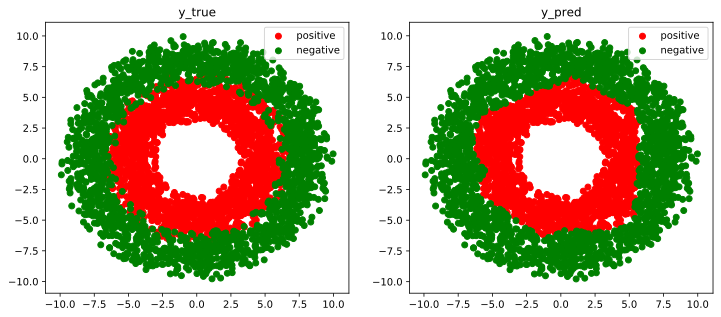

In [173]:
# 结果可视化
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:, 0], Xp[:, 1], c='r')
ax1.scatter(Xn[:, 0], Xn[:, 1], c='g')
ax1.legend(['positive', 'negative'])
ax1.set_title('y_true')

Xp_pred = tf.boolean_mask(X, tf.squeeze(model(X)>=0.5), axis=0)
Xn_pred = tf.boolean_mask(X, tf.squeeze(model(X)<0.5), axis=0)

ax2.scatter(Xp_pred[:, 0], Xp_pred[:, 1], c='r')
ax2.scatter(Xn_pred[:, 0], Xn_pred[:, 1], c='g')
ax2.legend(['positive', 'negative'])
ax2.set_title('y_pred')
fig.show()